# Run the Self-Organizing Map
Using the SOMOCLU library<br><br>
Training sample: KiDS<br>
Labeling sample: GAMA<br>
____


In [1]:
from astropy.io import fits
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

plt.rcParams.update({
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   :  1.5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

def Table_to_array(table):
    tuple_data = table.as_array()
    list_data  = [list(values) for values in tuple_data]
    array_data = np.array(list_data, dtype = np.float32)

    return array_data

In [2]:
#Load in KiDS data
with fits.open('/data2/lsajkov/mpdg/data_products/KiDS/KiDS_SOM_catalog_18Jul24.fits') as cat:
    KiDS_cat = Table(cat[1].data)

#Load in GAMA data
with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_17Jul24.fits') as cat:
    GAMA_cat = Table(cat[1].data)

In [3]:
#Select the needed training data
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_redshift_cut = KiDS_cat['redshift'] < 0.4
KiDS_size_cut = KiDS_cat['half_light_radius'] < 5

training_cat = KiDS_cat[KiDS_redshift_cut & KiDS_mag_cut & KiDS_size_cut]

training_data = training_cat[
                            'r_mag',
                            'ug_col',
                            'gr_col',
                            'ri_col',
                            'redshift',                            
                            ]

training_data_names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      'redshift',                            
                      ]

training_data = Table_to_array(training_data)

In [4]:
#Select the needed labeling data

GAMA_mag_cut = GAMA_cat['r_mag'] < 20.5
GAMA_redshift_cut = GAMA_cat['redshift'] < 0.4
GAMA_size_cut = GAMA_cat['half_light_radius'] < 5

labels_cat = GAMA_cat[GAMA_redshift_cut & GAMA_mag_cut & GAMA_size_cut]

labeling_data_inputs = labels_cat[
                                 'r_mag',
                                 'ug_col',
                                 'gr_col',
                                 'ri_col',
                                 'redshift',
                                 ]

labeling_data_inputs = Table_to_array(labeling_data_inputs)

labeling_data_outputs = labels_cat[
                                  'redshift',
                                  'mstar'
                                  ]

labeling_data_outputs = Table_to_array(labeling_data_outputs)

labeling_parameter_names = [
                           'redshift',
                           'mstar'
                           ]


In [5]:
print(f'Len of training data:\t\t{len(training_data)}')
print(f'Len of labeling data inputs:\t{len(labeling_data_inputs)}')
print(f'Len of labeling data outputs:\t{len(labeling_data_outputs)}')

Len of training data:		626112
Len of labeling data inputs:	46549
Len of labeling data outputs:	46549


___
Initialize & train the SOM

In [6]:
import somoclu

In [7]:
#set parameters
n_columns      = 40
n_rows         = 40

maptype        = 'toroid'
gridtype       = 'hexagonal'

initialization = 'pca'

neighborhood   = 'gaussian'
std_coeff      = 0.5

verbose        = 2

compactsupport = False

#training parameters
epochs        = 10

radius0       = 0
radiusN       = 1
radiuscooling = 'exponential'

scale0        = 0.65
scaleN        = 0.01
scalecooling  = 'exponential'

In [8]:
SOM = somoclu.Somoclu(n_columns      = n_columns,
                      n_rows         = n_rows,
                      maptype        = maptype,
                      gridtype       = gridtype,
                      initialization = initialization,
                      neighborhood   = neighborhood,
                      std_coeff      = std_coeff,
                      verbose        = verbose,
                      compactsupport = compactsupport,)

In [9]:
#Select subset of data
data_cut = 'all' #set to 'all' to use all data, otherwise set to an integer

print(f'Initial training data len:\t{len(training_data)}')
if data_cut != 'all':
    randomized_idx = np.arange(0, len(training_data))
    np.random.shuffle(randomized_idx)
    randomized_data_idx = randomized_idx[:data_cut]
    training_data = training_data[randomized_data_idx]
print(f'Subset training data len:\t{len(training_data)}')

Initial training data len:	626112
Subset training data len:	626112


In [10]:
SOM.train(data = training_data,
          epochs = epochs,
          radius0 = radius0, radiusN = radiusN, radiuscooling = radiuscooling,
          scale0 = scale0,   scaleN = scaleN,   scalecooling = scalecooling)

     10% [======                                            ]
     20% [===========                                       ]
     30% [================                                  ]
     40% [=====================                             ]
     50% [==========================                        ]
     60% [===============================                   ]
     70% [====================================              ]
     80% [=========================================         ]
     90% [==============================================    ]
    100% [===================================================]



Time for epoch 1: 8.36 Time for epoch 2: 7.944 Time for epoch 3: 8.215 Time for epoch 4: 8.909 Time for epoch 5: 8.747 Time for epoch 6: 8.617 Time for epoch 7: 12.09 Time for epoch 8: 16.77 Time for epoch 9: 14.03 Time for epoch 10: 11.62 

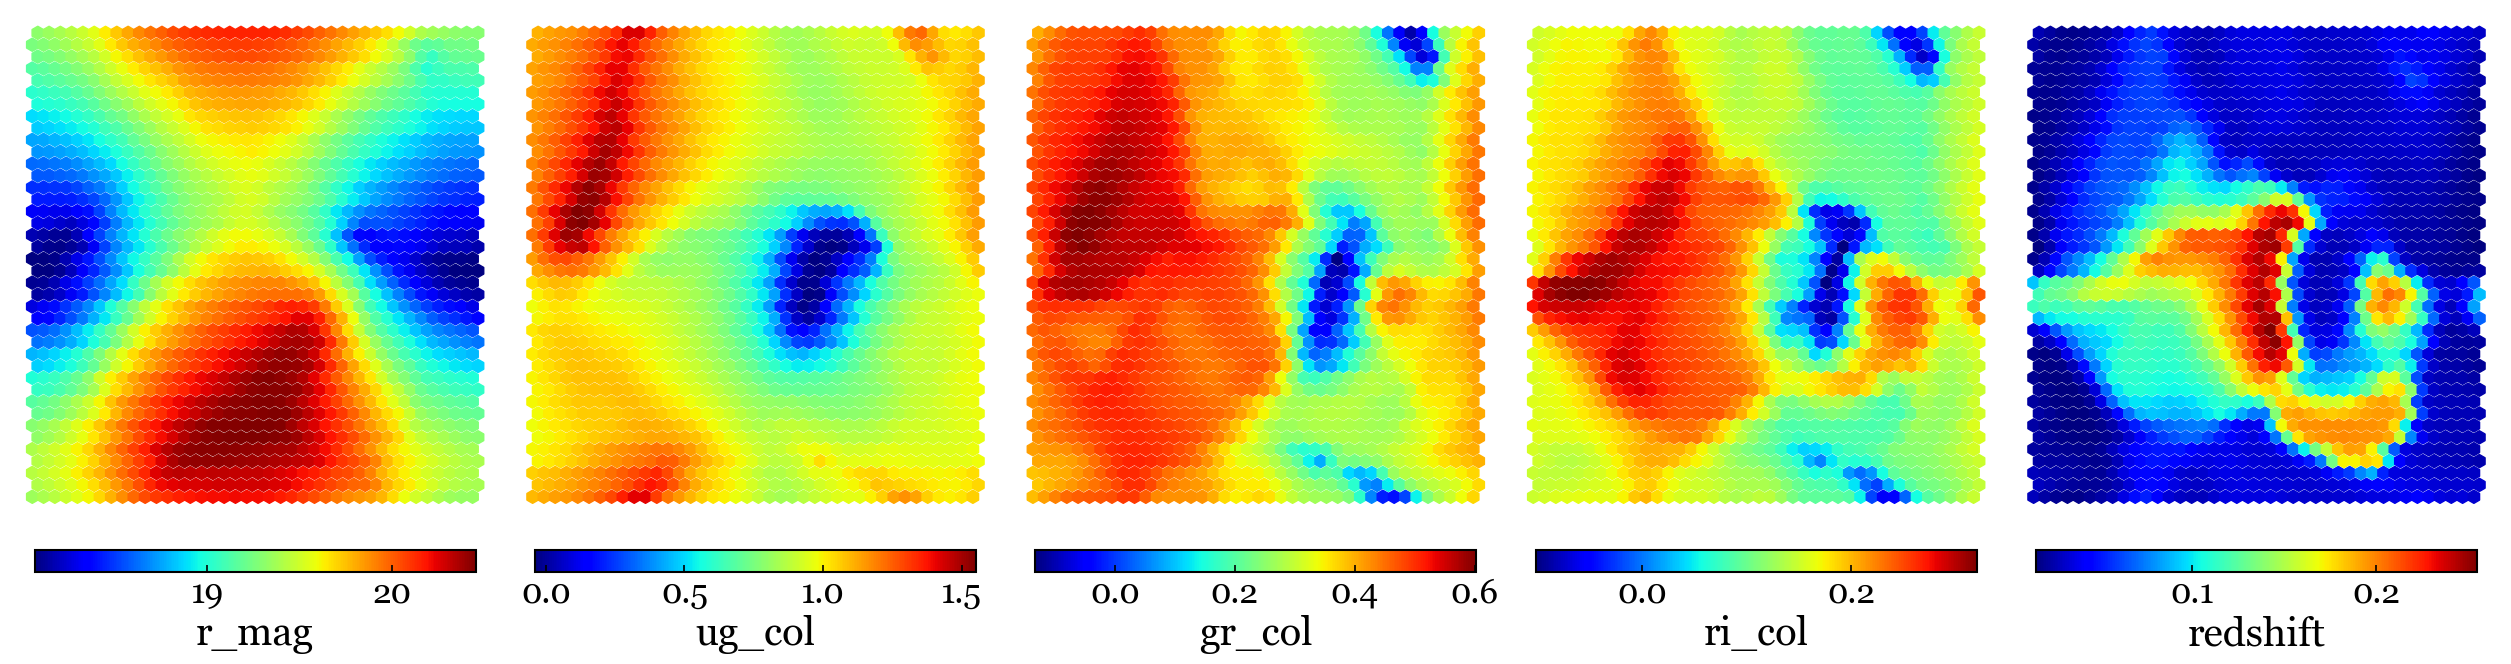

In [11]:
#Visualize trained SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                       np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)

    map = ax.scatter(*hexmesh, c = SOM.codebook[..., i], marker = 'h', cmap = 'jet', s = 90)
    ax.axis('off')
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = training_data_names[i], shrink = 0.9)

In [ ]:
training_activation_map = SOM.get_surface_state(data = training_data)
training_bmus = SOM.get_bmus(activation_map = training_activation_map)

___
Label the SOM & make predictions

In [12]:
labeling_activation_map = SOM.get_surface_state(data = labeling_data_inputs)
labeling_bmus = SOM.get_bmus(activation_map = labeling_activation_map)

In [25]:
n_params = np.shape(labeling_data_outputs)[1]

labeled_map_values = np.empty((n_rows, n_columns, n_params), dtype = object)
for index, _ in np.ndenumerate(labeled_map_values):
    labeled_map_values[index] = []

for vector_index in range(len(labeling_bmus)):
    for param in range(n_params):
        labeled_map_values[*labeling_bmus[vector_index], param].append(labeling_data_outputs[vector_index, param])

labeled_map = np.empty((n_rows, n_columns, n_params), dtype = float)
for index, values in np.ndenumerate(labeled_map_values):
    labeled_map[index] = np.mean(values)

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
#make mstar log
labeled_map[..., 1] = np.log10(labeled_map[..., 1])

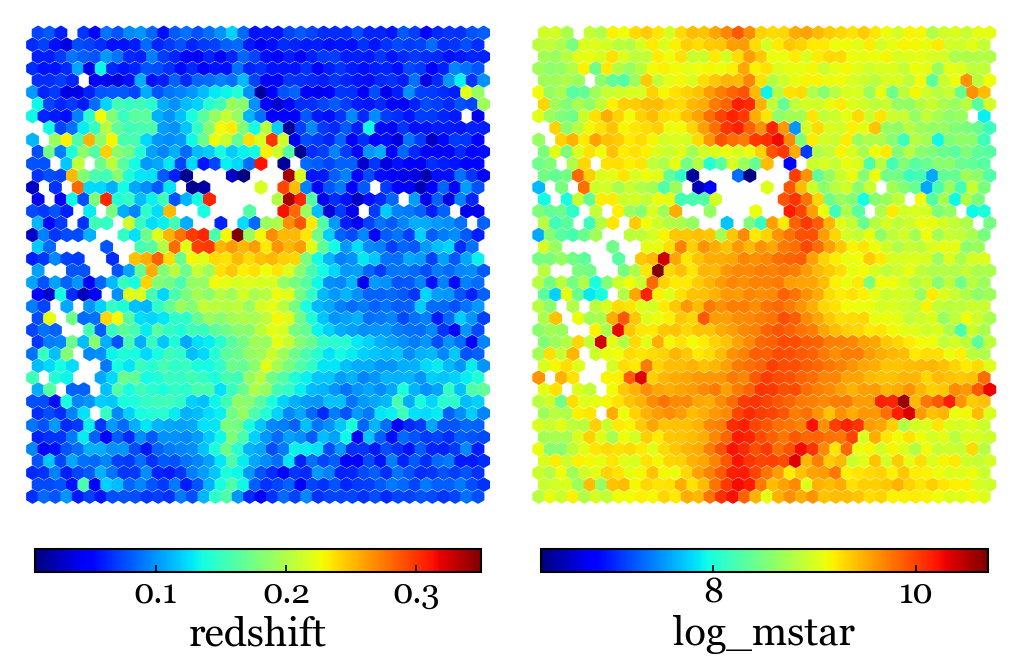

In [27]:
#Visualize labeled SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                       np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(n_params):
    ax = fig.add_subplot(1, 5, i + 1)

    map = ax.scatter(*hexmesh, c = labeled_map[..., i], marker = 'h', cmap = 'jet', s = 90)
    ax.axis('off')
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = ['redshift', 'log_mstar'][i], shrink = 0.9)

In [28]:
predicted_values_training = np.empty((len(training_data), n_params))
predicted_values_labeling = np.empty((len(labeling_data_inputs), n_params))

# for i, bmu in enumerate(training_bmus):
#     predicted_values_training[i] = labeled_map[*bmu]

for i, bmu in enumerate(labeling_bmus):
    predicted_values_labeling[i] = labeled_map[*bmu]

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/var/tmp/lsajkov/ipykernel_1546925/2927784228.py:22: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')


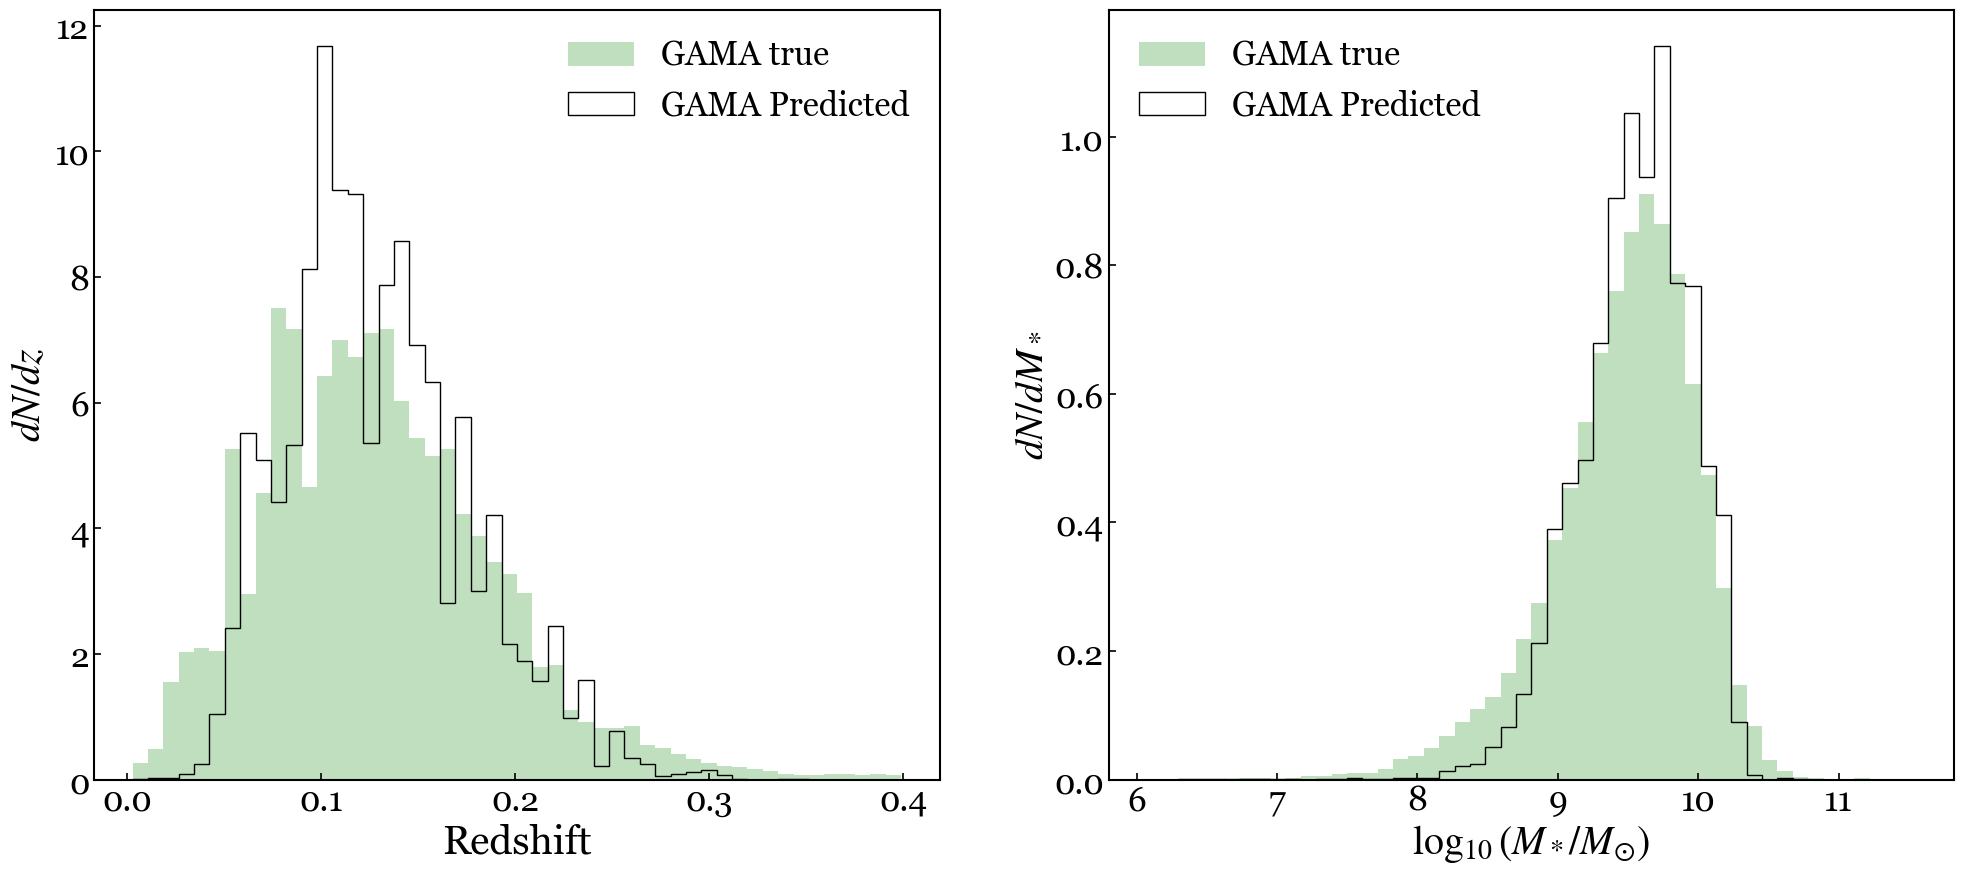

In [30]:
fig = plt.figure(figsize = (24, 10))

ax_l = fig.add_subplot(1, 2, 1)

bins = ax_l.hist(labeling_data_outputs[:, 0], bins = 50, density = True,
                 color = 'green', alpha = 0.25, label = 'GAMA true')[1]

ax_l.hist(predicted_values_labeling[:, 0], bins = bins, density = True,
          histtype = 'step', color = 'black', label = 'GAMA Predicted')

ax_l.set_xlabel('Redshift')
ax_l.set_ylabel('$dN/dz$')
ax_l.legend(frameon = False)

ax_r = fig.add_subplot(1, 2, 2)

bins = ax_r.hist(np.log10(labeling_data_outputs[:, 1]), bins = 50, density = True,
                 color = 'green', alpha = 0.25, label = 'GAMA true')[1]

ax_r.hist(predicted_values_labeling[:, 1], bins = bins, density = True,
          histtype = 'step', color = 'black', label = 'GAMA Predicted')
ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
ax_r.set_ylabel('$dN/dM_*$')
ax_r.legend(frameon = False)